(Kyla Jones running) from Elvis Eugene and Alexander Dowling

In [3]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, math
import pandas as pd
np.random.seed(200)
import reaction_models as rxn
import os

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### For new user:

In [4]:
# indicator to use Elvis data
new_user = input("Run as new user? (input [y]/[n]): \t")

if new_user == 'n':
    gen_new_data = False
    print('Running with Elvis Data')
    
elif new_user == 'y':
    gen_new_data = True
    username = input("Enter your initials: \t") # for creating file directories and names

else:
    print("Invalid input")

Run as new user? (input [y]/[n]): 	n
Running with Elvis Data


### Square Plots:

In [5]:
# modified from https://stackoverflow.com/questions/27579898/how-to-create-square-log-log-plots-in-matplotlib
def set_aspect_ratio(plot, aspect_ratio):
        x_min, x_max = plot.get_xlim()
        y_min, y_max = plot.get_ylim()
        return plot.set_aspect(aspect_ratio * ((abs(x_max - x_min)) / (abs(y_max - y_min))))

### Generate LHS Design

In [7]:
#Generate LHS Design
if gen_new_data == True:
    from pyDOE import lhs
    design = lhs(2, samples = 20, criterion = 'center')
    np.savetxt('lhs_20_'+username+'.csv', design, delimiter = ',')
    print('Succesfully initialized', username, 'design space')
    
elif gen_new_data == False:
    design = np.loadtxt('lhs_20.csv', delimiter = ',')
    print('Successfully loaded Elvis design space')
    
else:
    print('Error')
    
design

Successfully loaded Elvis design space


array([[0.175, 0.325],
       [0.975, 0.625],
       [0.525, 0.125],
       [0.325, 0.975],
       [0.025, 0.925],
       [0.125, 0.875],
       [0.575, 0.225],
       [0.675, 0.475],
       [0.625, 0.375],
       [0.425, 0.025],
       [0.275, 0.175],
       [0.825, 0.425],
       [0.775, 0.825],
       [0.475, 0.775],
       [0.725, 0.675],
       [0.875, 0.075],
       [0.375, 0.725],
       [0.075, 0.525],
       [0.925, 0.575],
       [0.225, 0.275]])

In [8]:
#Define values of independent variables for simulation
T_min = 293.15
T_max = 473.15
dT = T_max - T_min

CA0_min = 1.0
CA0_max = 5.0
dCA0 = CA0_max - CA0_min

#Convert LHS from 0 to 1 variable values
T_vect = design[:,0]*dT + T_min
CA0_vect = design[:,1]*dCA0 + CA0_min

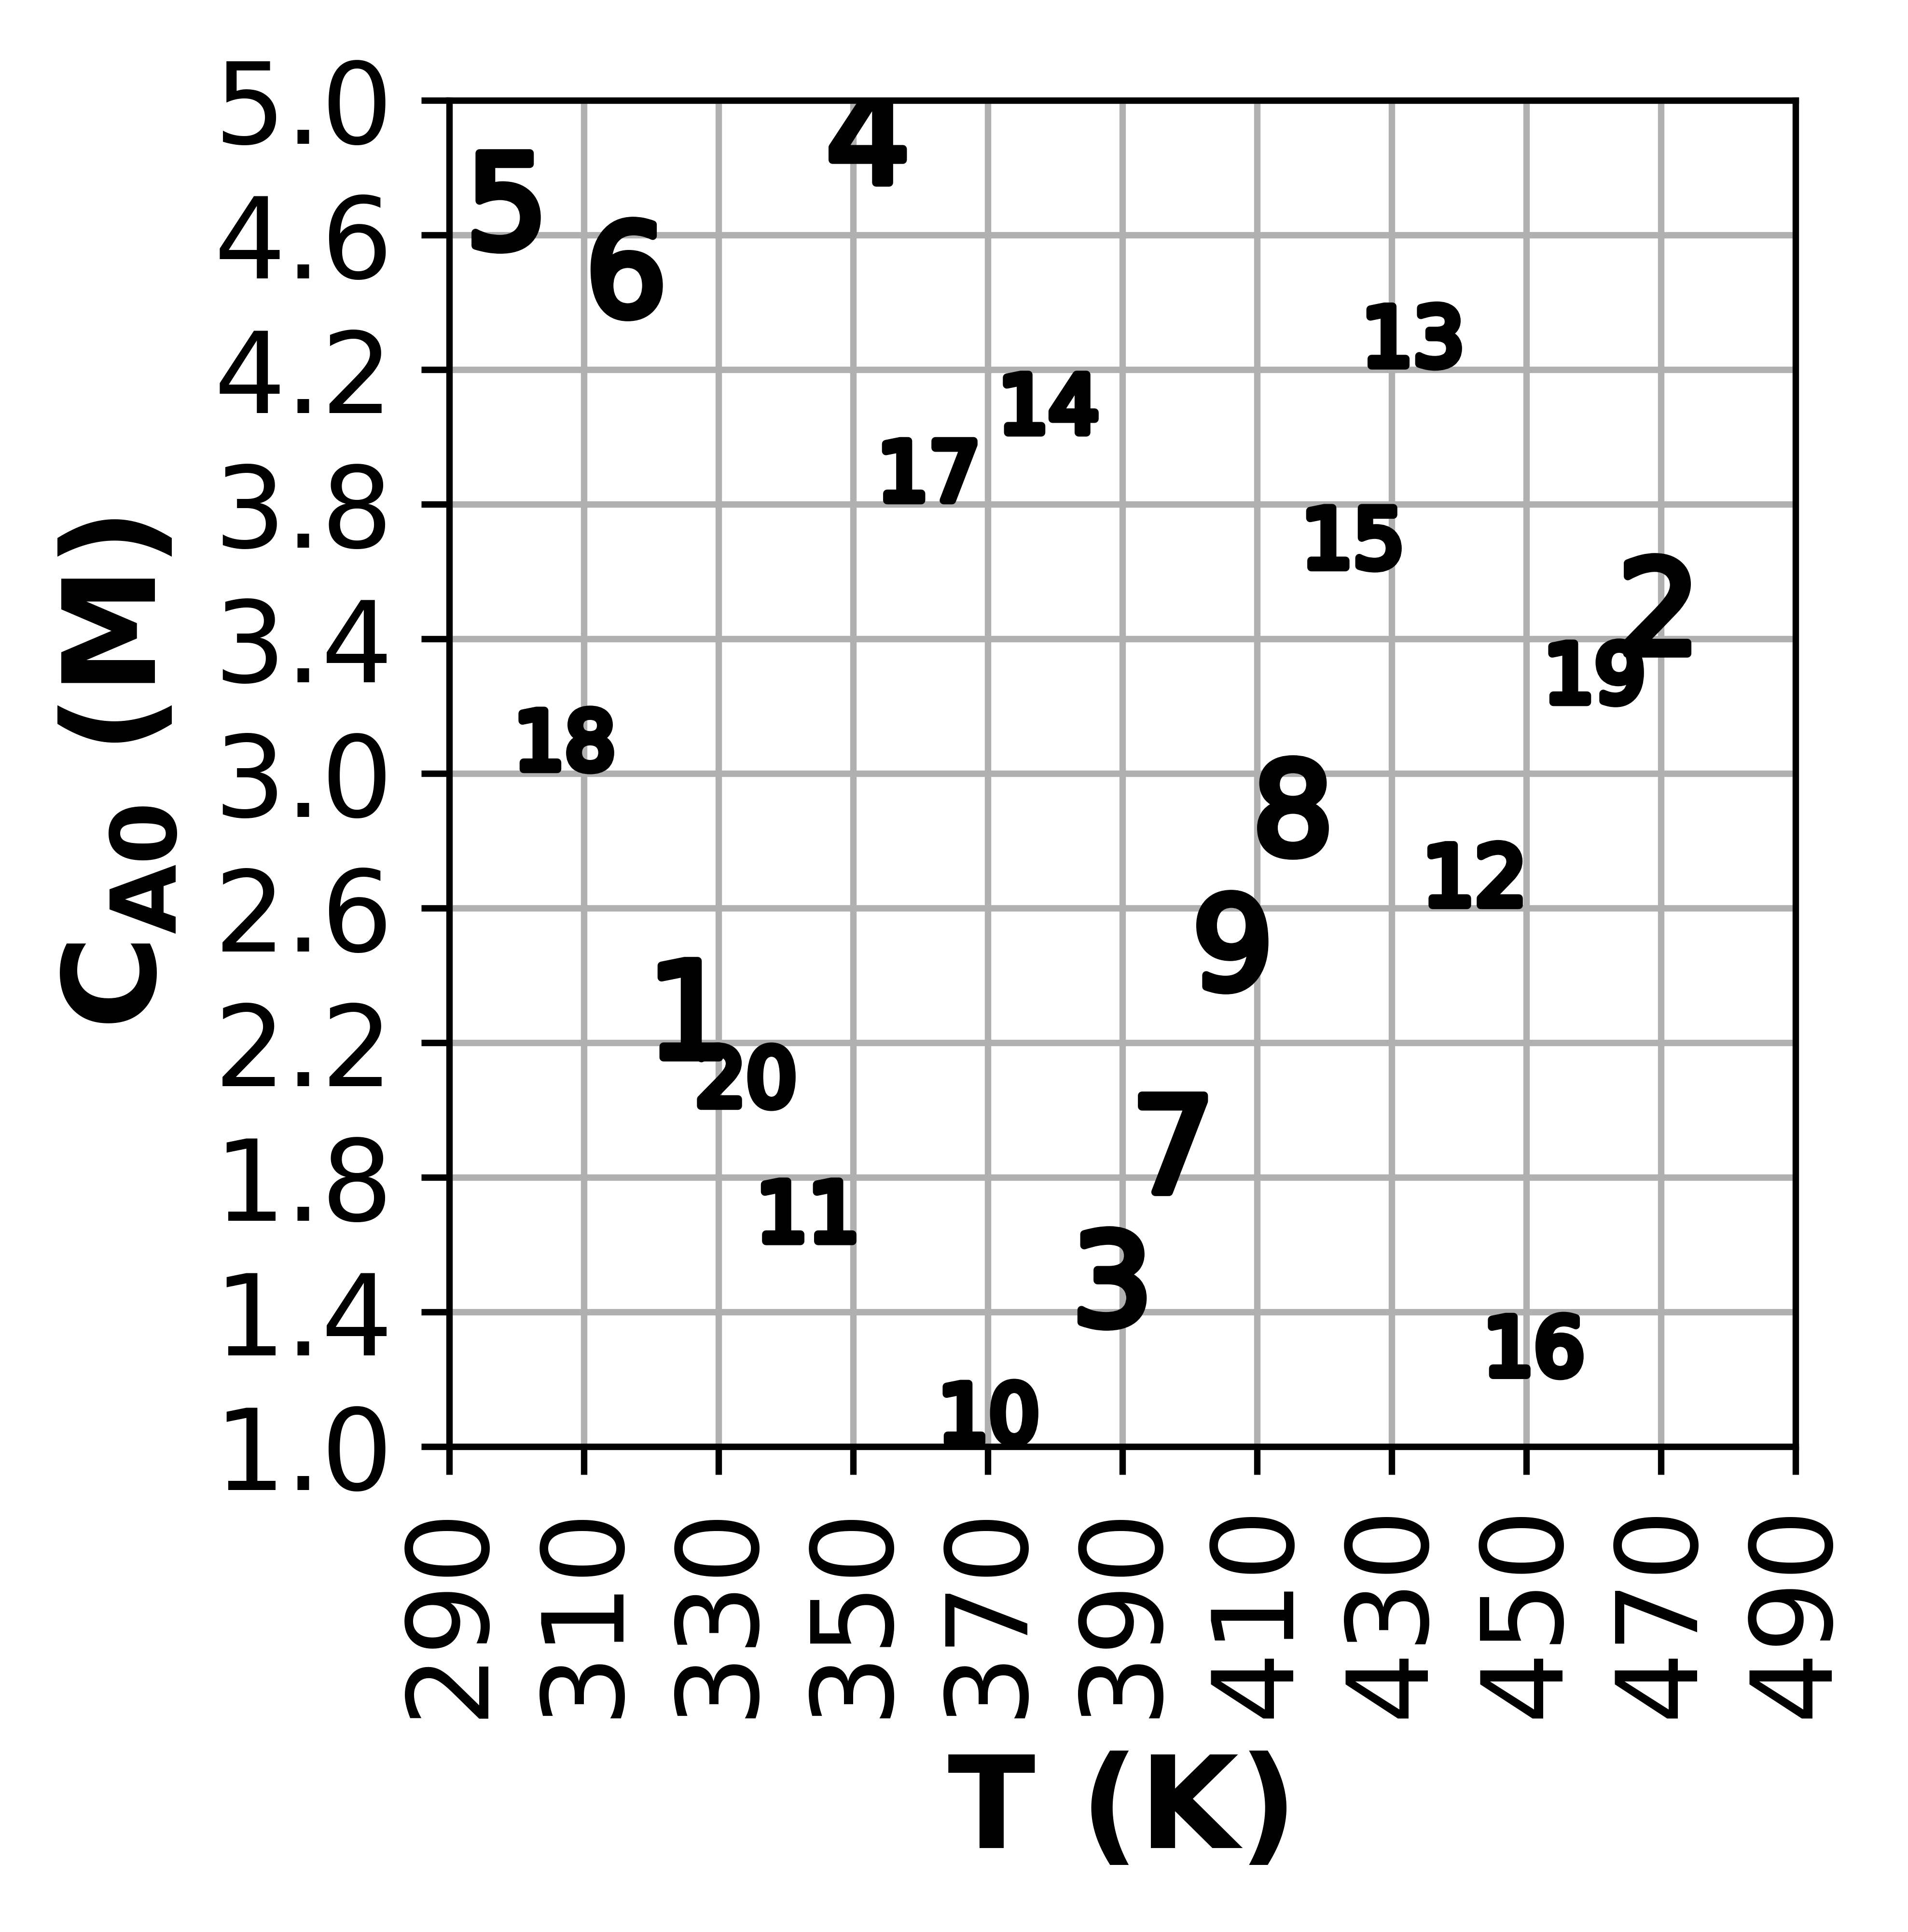

In [10]:
#plot the experiments at which the observations were recorded

w_in = 3. #width in inches
h_in = 4.0 #height in inches
dpi_fig = 1200 #pixel density in dots per inch

fig, ax = plt.subplots(figsize = (w_in, h_in), dpi = dpi_fig)

for i in range(T_vect.shape[0]):
    plt.plot(T_vect[i], CA0_vect[i], 'k', marker = r'${0}$'.format(i+1), markersize = 12 );
plt.xlabel("T (K)",fontsize=16,fontweight='bold')
plt.ylabel(r'$\bf{C_{A0}}$ (M)',fontsize=16, fontweight='bold')
plt.xlim(T_min,T_max)
plt.ylim(CA0_min,CA0_max)
plt.xticks(np.arange(290,491,20),rotation='vertical')
plt.yticks(np.arange(1.0,5.1,0.4))
plt.xlim([290,490])
plt.ylim([1,5])
plt.grid(True)
set_aspect_ratio(ax, 1.0)
plt.savefig('fig-rxn_lhs.png',dpi=dpi_fig,bbox_inches='tight')

## Generate synthetic experimental data
### Directory name to save training data in

In [13]:
# directory name to save training data in
if gen_new_data == False:
    dir_name = 'training_data_small_noise_full_physics_2'
    print('Data directory: \t', dir_name)
    
else:
    dir_name = 'training_data_small_noise_full_physics_2_'+username
    os.mkdir(dir_name)
    print('Data directory: \t', dir_name)

Data directory: 	 training_data_small_noise_full_physics_2


In [14]:
# Define truth variables for simulation
A_true = np.array([200, 100, 50])
E_true = np.array([10, 20, 15])

theta_true = np.hstack([A_true, E_true])

# Define measurement error
stdev_m_error = 0.03 # mol/L

# list of data sets
data = []

if gen_new_data == True:
    ## Generate data

    # declare time for measurements
    t_exp = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) # for new training set with more timeseries data
    n = len(t_exp)

    for i in range(len(design)):

        T = T_vect[i]
        CA0 = CA0_vect[i]

        # evaluate model to generate data
        CA_exp1, CB_exp1, CC_exp1 = rxn.full_physics_model_2(theta_true, t_exp, CA0, T)

        # save data without noise
        # store in pandas dataframe
        data_temp = pd.DataFrame({"exp" : str(i+1), "time" : t_exp, "CA" : CA_exp1, "CB" : CB_exp1, "CC" : CC_exp1, "temp": np.ones(n)*T, "CA0" : np.ones(n)*CA0})

        # save to text file:
        data_temp.to_csv(dir_name+"/rxn_exp_"+str(i+1)+"_nonoise.csv", index = False)

        # add measurement error:
        CA_exp1 += np.random.normal(0 , stdev_m_error, n)
        CB_exp1 += np.random.normal(0 , stdev_m_error, n)
        CC_exp1 += np.random.normal(0 , stdev_m_error, n)

        # store in pandas dataframe
        data_temp = pd.DataFrame({"exp":str(i+1),"time":t_exp,"CA":CA_exp1,"CB":CB_exp1,"CC":CC_exp1,"temp":np.ones(n)*T,"CA0":np.ones(n)*CA0})

        # save to text file
        data_temp.to_csv(dir_name+"/rxn_exp_"+str(i+1)+".csv",index = False)

        # add to array
        data.append(data_temp)

        #save true values of simulation to file
        np.savetxt(dir_name+'/A_true.csv',A_true,delimiter=',')
        np.savetxt(dir_name+'/E_true.csv',E_true,delimiter=',')

elif gen_new_data == False:
    for i in range(len(design)):
        # load from Elvis .csv
        data_temp = pd.read_csv(dir_name+"/rxn_exp_"+str(i)+".csv")
        
        # add to array
        data.append(data_temp)
    print("No new data generated")

No new data generated


## Plot synthetic data and true model

In [16]:
for i in range(len(data)):
    
    print("\nData set "+str(i+1)+" ... ")
    
    # Print data frame
    print(data[i].head())
    
    # Plot data and model
    rxn.plot_experiments_model(theta_true, data[i], rxn.full_physics_model_2, fname='full_physics_kinetics/fig-exp_')
    plt.show()


Data set 1 ... 
   exp  time        CA        CB        CC    temp  CA0
0    0   0.0  2.256472  0.039099 -0.038813  324.65  2.3
1    0   0.1  1.471199  0.891312  0.025903  324.65  2.3
2    0   0.2  0.903812  1.436696  0.001404  324.65  2.3
3    0   0.3  0.556087  1.758886 -0.003496  324.65  2.3
4    0   0.4  0.382732  1.842570  0.076208  324.65  2.3

Data set 2 ... 
   exp  time        CA        CB        CC    temp  CA0
0    1   0.0  3.566401  0.019293  0.028411  468.65  3.5
1    1   0.1  0.832477  2.301995  0.346226  468.65  3.5
2    1   0.2  0.276210  2.075347  0.985395  468.65  3.5
3    1   0.3  0.241892  1.765442  1.492689  468.65  3.5
4    1   0.4  0.145506  1.580223  1.758631  468.65  3.5

Data set 3 ... 
   exp  time        CA        CB        CC    temp  CA0
0    2   0.0  1.499098 -0.025891 -0.012122  387.65  1.5
1    2   0.1  0.607929  0.896706 -0.044813  387.65  1.5
2    2   0.2  0.291044  1.181096  0.023871  387.65  1.5
3    2   0.3  0.197067  1.246566  0.094180  387.65  1

## No need for the cell below.

In [10]:
# verify that two sets of data were generated using the same model parameters
# file paths

# if ElvisData == True:
#     # file paths
#     dataset_1_path = 'training_data_small_noise_full_physics_2'
#     dataset_2_path = 'training_data_small_noise_full_physics_2-verification'
#     # number of datasets
#     n_dset = 20
#     # lists for data
#     data1 = []
#     data2 = []

#     for i in range(n_dset):
#         # load from csv
#         data_1_temp = pd.read_csv(dataset_1_path+"/rxn_exp_"+str(i)+".csv")
#         ### ask about this tomorrow
#         data_2_temp = pd.read_csv(dataset_1_path+"/verify-rxn_exp_"+str(i)+".csv")

#         # add to array
#         data1.append(data_1_temp)
#         data2.append(data_2_temp)
    
#         print("\nData set 1 | Exp: "+str(i)+" ... ")
    
#         # Print data frame
#         print(data1[i].head())
    
#         print("\nData set 2 | Exp: "+str(i)+" ... ")
    
#         # Print data frame
#         print(data2[i].head())
    
#         # Plot both datasets and verify if they are identical
#         rxn.verify_model(data1[i],data2[i])

# # End for
# else:
#     print('further clarification needed')
    
# dataset_1_path = 'training_data_small_noise_full_physics_2_KJ'

# # dataset_2_path = 'training_data_small_noise_full_physics_2_KJ-verification'
# # numbers of datasets
# n_dset = 20
# # lists for data
# data1 = []
# data2 = []

# for i in range(n_dset):
#     # load from csv
#     data_1_temp = pd.read_csv(dataset_1_path+"/verify-rxn_exp_"+str(i)+"_KJ.csv")
#     data_2_temp = pd.read_csv(dataset_1_path+"/verify-rxn_exp_"+str(i)+"_KJ.csv")
    
#     # add to array
#     data1.append(data_1_temp)
#     data2.append(data_2_temp)

#     print("\nData set 1 | Exp: "+str(i)+" ... ")

#     # Print data frame
#     print(data1[i].head())
    
#     print("\nData set 2 | Exp: "+str(i)+" ... ")

#     # Print data frame
#     print(data2[i].head())
    
#     # Plot both datasets and verify if they are identical
#     rxn.verify_model(data1[i],data2[i])

# #End for
